In [2]:
#Googleドライブのマウント

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#必要なライブラリのインポート
import numpy as np
import pandas as pd
#import pandas_profiling as pdp

#データ可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
 
#決定木ライブラリ
from sklearn import tree
 
#訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

In [4]:
#データcsvの読み込みと表示
df = pd.read_csv('/content/drive/MyDrive/superconduct_predict/train.csv')
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,...,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425,1010.544286,718.152900,938.512777,1.305967,0.783207,810.6,739.575000,323.811808,355

In [5]:
#https://rin-effort.com/2019/12/25/machine-learning-4/
#学習データと、検証用データの分割
train_set, test_set = train_test_split(df, test_size=0.2, random_state=4)
print(len(train_set))
print(len(test_set))

17010
4253


In [6]:
#訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_train = train_set.drop('critical_temp', axis=1)
y_train = train_set['critical_temp']

#モデル評価用データを説明変数データ(X_test)と目的変数データ(y_test)に分割
X_test = test_set.drop('critical_temp', axis=1)
y_test = test_set['critical_temp']


In [7]:
#回帰木モデルのインスタンス（空の箱みたいなモノ）を作る。回帰木の最大の深さは3。
clf = tree.DecisionTreeRegressor(max_depth=3,random_state = 0)

In [8]:
#訓練用データの説明変数と目的変数を渡して学習	
model = clf.fit(X_train, y_train)

In [9]:
#「predicted」には、モデル評価用データの説明変数から導き出された予測値が収納
predicted = model.predict(X_test)
print(predicted)

[22.13525228  4.88780003 63.89195881 ... 23.78083869  4.88780003
 63.89195881]


In [10]:
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSLE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSLE = {}'.format(str(round(RMSLE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
    plt.show()

In [11]:
#可視化できる関数に突っ込めるように、予測値と正答値を加工
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
pred_df.columns = ['true', 'pred']
pred_df.head()

,true,pred
0,11.30,22.135252
1,8.00,4.887800
2,89.66,63.891959
3,14.00,4.887800
4,15.00,23.780839


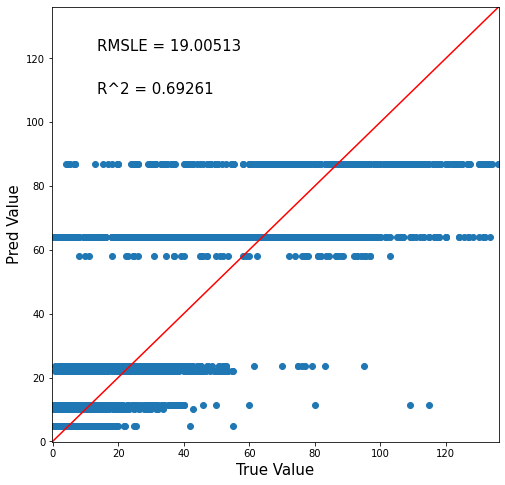

In [12]:
%matplotlib inline
True_Pred_map(pred_df)

In [13]:
#回帰木の深さを1～20まで変化させて、それぞれのR^2値を記録する
R2_list = []
count = []
for i in range(1, 21):
    clf = tree.DecisionTreeRegressor(max_depth=i)
    model = clf.fit(X_train, y_train)
    predicted = model.predict(X_test)
    pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
    pred_df.columns = ['true', 'pred']
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    R2_list.append(R2)
    count.append(i)

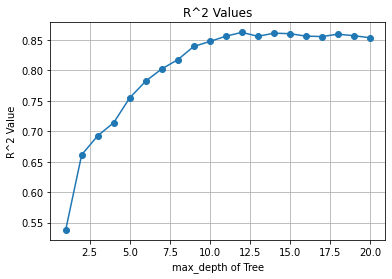

In [14]:
#R2_listの値を可視化
%matplotlib inline
plt.plot(count, R2_list, marker="o")
plt.title("R^2 Values")
plt.xlabel("max_depth of Tree")
plt.ylabel("R^2 Value")
plt.grid(True)

[13.93285714  6.46068182 87.54587006 ... 37.          4.58027778
 51.17862745]


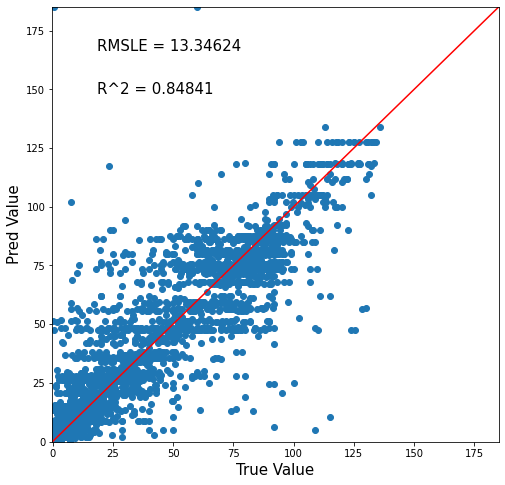

In [15]:
#R2が飽和する深さ10の結果をプリント
#回帰木モデルのインスタンス（空の箱みたいなモノ）を作る。回帰木の最大の深さは3。
clf_10 = tree.DecisionTreeRegressor(max_depth=10,random_state = 0)
#訓練用データの説明変数と目的変数を渡して学習	
model_10 = clf_10.fit(X_train, y_train)
#「predicted」には、モデル評価用データの説明変数から導き出された予測値が収納
predicted_10 = model_10.predict(X_test)
print(predicted_10)
#可視化できる関数に突っ込めるように、予測値と正答値を加工
pred_df_10 = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted_10)], axis=1)
pred_df_10.columns = ['true', 'pred']
%matplotlib inline
True_Pred_map(pred_df_10)

In [16]:
# 決定木の重要度を可視化
feature = clf_10.feature_importances_
label = X_train.columns
indices = np.argsort(feature)
print(feature)
print(indices[0:20])


[2.52731288e-07 6.86458499e-06 6.54429659e-03 8.11428945e-04
 1.66342468e-03 1.76347786e-03 2.66749224e-03 2.42518845e-04
 7.05149623e-03 3.29969089e-02 1.74912064e-03 3.19510079e-03
 2.93312982e-03 1.02405040e-03 1.57886075e-03 1.06178102e-03
 1.62348317e-03 3.85308227e-03 3.20556264e-04 1.72896048e-03
 2.86627959e-03 4.34556626e-04 2.32957878e-03 1.11554679e-04
 2.50605767e-03 5.57277120e-04 1.30153423e-03 1.05552059e-03
 3.19183366e-03 1.10387266e-02 4.08927029e-03 1.07786003e-02
 4.32983576e-03 9.70588052e-05 1.34814489e-03 9.27258269e-03
 3.31161472e-03 5.29222577e-03 6.66333637e-04 2.04463475e-03
 3.32424636e-03 1.70870180e-04 1.61449765e-03 7.96160134e-03
 1.90265595e-03 1.38027083e-03 2.92306723e-04 7.18078644e-03
 3.87770474e-03 9.36674026e-04 1.84507587e-02 4.97846288e-04
 1.49786635e-03 1.63900984e-03 6.87355657e-04 8.87262040e-04
 1.13308119e-03 3.22436550e-05 1.14838667e-03 3.38632646e-04
 2.50656898e-03 1.08949095e-03 5.83259399e-04 1.48103970e-03
 1.34295073e-01 3.050292

In [17]:
# 決定木の重要度を可視化
feature = clf_10.feature_importances_
label = X_train.columns
indices = np.argsort(feature)

Text(0.5, 0, 'Feature Importance')

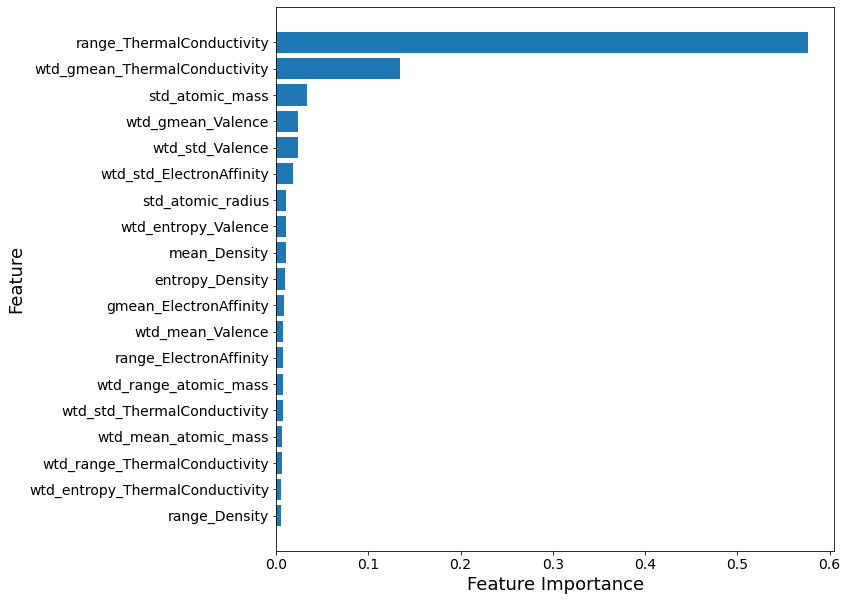

In [18]:
# 特徴量の重要度の棒グラフ
fig =plt.figure (figsize = (10,10))

#plt.barh(range(len(feature)), feature[indices])
plt.barh(range(62,81), feature[indices[62:81]])

#plt.yticks(range(len(feature)), label[indices[]], fontsize=14)
plt.yticks(range(62,81), label[indices[62:81]], fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("Feature", fontsize=18)
plt.xlabel("Feature Importance", fontsize=18)

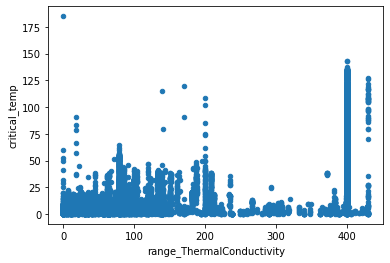

In [26]:
df.plot.scatter(x='range_ThermalConductivity', y='critical_temp')

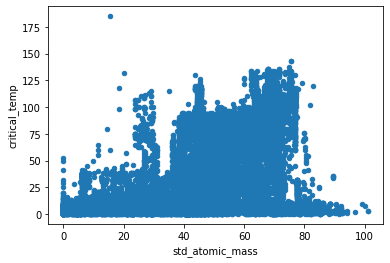

In [21]:
df.plot.scatter(x='std_atomic_mass', y='critical_temp')

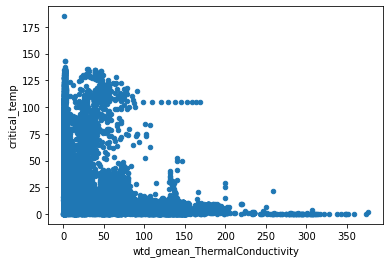

In [23]:
df.plot.scatter(x='wtd_gmean_ThermalConductivity', y='critical_temp')

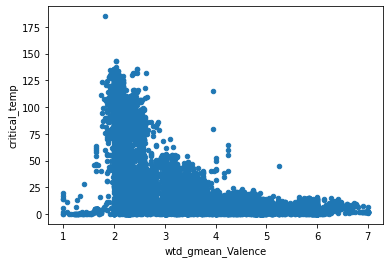

In [24]:
df.plot.scatter(x='wtd_gmean_Valence', y='critical_temp')

In [ ]:
##pandas_profilingの更新
#https://yksnyh-lab.cyou/colab-pandas_profling-error/
#!pip install -U pandas_profiling

##項目の概要
#%%time
#profile = pdp.ProfileReport(df)
#profile.to_file("/content/drive/MyDrive/superconduct_predict/myoutputfile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 24min 44s, sys: 49.4 s, total: 25min 34s
Wall time: 25min 30s
